In [1]:
import pandas as pd

In [5]:
df = pd.read_csv("../Data_and_Results/catalog_FULL.csv")

# df = df[~df["[24]"].isnull()]
# df.head()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26903 entries, 0 to 26902
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   RA         26903 non-null  object 
 1   December   26903 non-null  float64
 2   Catalog    26903 non-null  object 
 3   OGClass    26903 non-null  object 
 4   [3.6]      26903 non-null  float64
 5   e_[3.6]    26903 non-null  float64
 6   [4.5]      26903 non-null  float64
 7   e_[4.5]    26903 non-null  float64
 8   [5.8]      26903 non-null  float64
 9   e_[5.8]    26903 non-null  float64
 10  [8]        26903 non-null  float64
 11  e_[8]      26903 non-null  float64
 12  [24]       4173 non-null   float64
 13  e_[24]     4173 non-null   float64
 14  Target     26903 non-null  int64  
 15  Predict    26903 non-null  int64  
 16  CIProb     26903 non-null  float64
 17  CIIProb    26903 non-null  float64
 18  OtherProb  26903 non-null  float64
dtypes: float64(14), int64(2), object(3)
memory usa

In [10]:
# Collect all classes of YSOs
df_Other = df[df["OGClass"]=='Other  ']

df_I_1 = pd.merge_ordered(df[df["OGClass"]=='aint   '],df[df["OGClass"]=='  0/I  '])
df_I_2 = pd.merge_ordered(df_Other[df_Other["Target"]==0], df[df["OGClass"]=='roto   '])
df_I = pd.merge_ordered(df_I_1,df_I_2)
df_I["OGTarget"] = 0 # Keep track of original target

df_II_1 = pd.merge_ordered(df[df["OGClass"]=='   II  '],df[df["OGClass"]=='isks   '])
df_II_2 = pd.merge_ordered(df_Other[df_Other["Target"]==1], df[df["OGClass"]=='   TD  '])
df_II = pd.merge_ordered(df_II_1,df_II_2)
df_II["OGTarget"] = 1 # Keep track of original target

# Collect over-arching classes
df_YSO = pd.merge_ordered(df_I, df_II)
df_YSO["Target"] = 0 # Make new Target designation to separate YSO, EG, Stars

df_AGN = df[df["OGClass"]=='  AGN  ']
df_AGN["OGTarget"] = 4 # Keep track of original target
df_PAH = df[df["OGClass"]=='  PAH  ']
df_PAH["OGTarget"] = 5 # Keep track of original target
df_SHO = df[df["OGClass"]=='SHOCK  ']
df_SHO["OGTarget"] = 6 # Keep track of original target

df_Other["OGTarget"] = 7 # Keep track of original target

df_EG_1 = pd.merge_ordered(df[df["OGClass"]=='  AGN  '],df[df["OGClass"]=='  PAH  '])
df_EG_2 = pd.merge_ordered(df_Other[df_Other["Target"]==5], df[df["OGClass"]=='SHOCK  '])
df_EG_3 = pd.merge_ordered(df_Other[df_Other["Target"]==4], df_Other[df_Other["Target"]==3])
df_EG_4 = pd.merge_ordered(df_EG_1, df_Other[df_Other["Target"]==2])
df_EG_5 = pd.merge_ordered(df_EG_2, df_EG_3)
df_EG = pd.merge_ordered(df_EG_4, df_EG_5)
df_EG["Target"] = 1 # Make new Target designation to separate YSO, EG, Stars


# For now have Class III/field stars class marked as regular stars since most will likely be field stars
df_III_F = df[df["OGClass"]=='III/F  ']
df_III_F["OGTarget"] = 3 # Keep track of original target 
df_Stars = pd.merge_ordered(df_Other[df_Other["Target"]==6],df_III_F)
df_Stars["Target"] = 2 # Make new Target designation to separate YSO, EG, Stars

df_1 = pd.merge_ordered(df_YSO,df_EG)
df_NEW = pd.merge_ordered(df_1,df_Stars)

df_NEW.head()

/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_85393/1580378669.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AGN["OGTarget"] = 4 # Keep track of original target
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_85393/1580378669.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PAH["OGTarget"] = 5 # Keep track of original target
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_85393/1580378669.py:23: SettingWithCopyWarning: 
A value is trying to be set on a cop

,RA,December,Catalog,OGClass,[3.6],e_[3.6],[4.5],e_[4.5],[5.8],e_[5.8],[8],e_[8],[24],e_[24],Target,Predict,CIProb,CIIProb,OtherProb,OGTarget
0,-81.3493440,5.358538,1,Other,13.184,0.006,13.206,0.009,13.105,0.043,13.067,0.059,NaN,NaN,2,2,0.0,0.000000,1.000000,7.0
1,-81.3501025,5.371680,1,Other,10.191,0.002,10.256,0.002,10.222,0.006,10.141,0.007,NaN,NaN,2,2,0.0,0.000002,0.999998,7.0
2,-81.3561284,5.303469,1,Other,13.921,0.007,13.886,0.013,13.859,0.079,14.207,0.189,NaN,NaN,2,2,0.0,0.000000,1.000000,7.0
3,-81.3607678,5.345007,1,Other,10.998,0.002,11.011,0.002,10.965,0.009,10.962,0.011,NaN,NaN,2,2,0.0,0.000000,1.000000,7.0
4,-81.3646088,5.353886,1,Other,13.920,0.009,13.934,0.010,13.880,0.092,13.789,0.098,NaN,NaN,2,2,0.0,0.000000,1.000000,7.0


In [11]:
print(df_I.shape)
print(df_II.shape)
print(df_III_F.shape)

print(df_YSO.shape)
print(df_EG.shape)
print(df_Stars.shape)

df["Catalog"].unique()


(399, 20)
(2679, 20)
(6893, 20)
(3078, 20)
(1949, 20)
(21786, 20)


array(['0', '1', '1 D', '1 F', '1 P'], dtype=object)

## CM21 - G-targets

We want to access original classifications, but to begin we will use the targets.
* 0: Class I -- YSO (0)
* 1: Class II -- YSO (0)
* 2: Galaxies -- EG (1)
* 3: AGNs -- EG (1) 
* 4: Shocks -- EG (1)
* 5: PAHs -- EG (1)
* 6: Stars -- Stars (2)

In [138]:
df_YSO = pd.merge_ordered(df[df["Target"]==0],df[df["Target"]==1])
df_YSO["Target"] = 0
print(df_YSO.shape)

df_EG_1 = pd.merge_ordered(df[df["Target"]==2],df[df["Target"]==3])
df_EG_2 = pd.merge_ordered(df[df["Target"]==4],df[df["Target"]==5])
df_EG = pd.merge_ordered(df_EG_1,df_EG_2)
df_EG["Target"] = 1 
print(df_EG.shape)
df_Stars = df[df["Target"]==6]
df_Stars["Target"] = 2

df_1 = pd.merge_ordered(df_YSO,df_EG)
df_NEW = pd.merge_ordered(df_1,df_Stars)

print(df_Stars.shape)

(3073, 19)
(2034, 19)
(21796, 19)


/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_52018/3473024199.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Stars["Target"] = 2


In [ ]:
df

,Unnamed: 0,3.6,d_3.6,4.5,d_4.5,5.8,d_5.8,8,d_8,24,d_24,target,pred,P(CI),P(CII),P(Other)
0,0,10.320,0.003,10.170,0.003,10.070,0.005,10.030,0.008,-99.000,-99.000,6,2,0.000000,0.000057,0.999943
1,1,11.620,0.003,11.600,0.004,11.550,0.016,11.560,0.035,-99.000,-99.000,6,2,0.000000,0.000000,1.000000
2,2,13.380,0.007,13.280,0.011,13.270,0.050,13.780,0.155,-99.000,-99.000,6,2,0.000000,0.000000,1.000000
3,3,12.520,0.005,12.520,0.006,12.400,0.030,12.410,0.053,-99.000,-99.000,6,2,0.000000,0.000000,1.000000
4,4,13.710,0.009,13.660,0.013,13.600,0.069,13.670,0.148,-99.000,-99.000,6,2,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26898,26898,13.826,0.014,13.782,0.020,13.634,0.104,13.645,0.184,-99.000,-99.000,6,2,0.000000,0.000001,0.999999
26899,26899,13.393,0.010,13.286,0.011,13.124,0.066,13.077,0.084,-99.000,-99.000,6,2,0.000001,0.000025,0.999974
26900,26900,14.150,0.015,13.905,0.022,13.084,0.076,10.324,0.014,8.323,0.095,2,2,0.000000,0.000000,1.000000
26901,26901,10.513,0.003,10.456,0.002,10.400,0.009,10.420,0.010,-99.000,-99.000,6,2,0.000000,0.000000,1.000000


In [ ]:
df_NEW


,Unnamed: 0,3.6,d_3.6,4.5,d_4.5,5.8,d_5.8,8,d_8,24,d_24,target,pred,P(CI),P(CII),P(Other)
0,0,10.320,0.003,10.170,0.003,10.070,0.005,10.030,0.008,-99.000,-99.000,2,2,0.000000,0.000057,0.999943
1,1,11.620,0.003,11.600,0.004,11.550,0.016,11.560,0.035,-99.000,-99.000,2,2,0.000000,0.000000,1.000000
2,2,13.380,0.007,13.280,0.011,13.270,0.050,13.780,0.155,-99.000,-99.000,2,2,0.000000,0.000000,1.000000
3,3,12.520,0.005,12.520,0.006,12.400,0.030,12.410,0.053,-99.000,-99.000,2,2,0.000000,0.000000,1.000000
4,4,13.710,0.009,13.660,0.013,13.600,0.069,13.670,0.148,-99.000,-99.000,2,2,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26898,26898,13.826,0.014,13.782,0.020,13.634,0.104,13.645,0.184,-99.000,-99.000,2,2,0.000000,0.000001,0.999999
26899,26899,13.393,0.010,13.286,0.011,13.124,0.066,13.077,0.084,-99.000,-99.000,2,2,0.000001,0.000025,0.999974
26900,26900,14.150,0.015,13.905,0.022,13.084,0.076,10.324,0.014,8.323,0.095,1,2,0.000000,0.000000,1.000000
26901,26901,10.513,0.003,10.456,0.002,10.400,0.009,10.420,0.010,-99.000,-99.000,2,2,0.000000,0.000000,1.000000


## Save new values

In [14]:
Inputs = df_NEW[["[3.6]","e_[3.6]","[4.5]","e_[4.5]","[5.8]","e_[5.8]","[8]","e_[8]"]].values.astype(float)

Targets = df_NEW[["Target"]].values.astype(float)

OGTargets = df_NEW[["OGTarget"]].values.astype(float)

In [16]:
import numpy as np

np.save("../Data_and_Results/Inputs_YSO_EG_Stars.npy",Inputs)
np.save("../Data_and_Results/Targets_YSO_EG_Stars.npy",Targets)
np.save("../Data_and_Results/OGTargets_YSO_EG_Stars.npy",OGTargets)

array([[<AxesSubplot:title={'center':'Target'}>]], dtype=object)

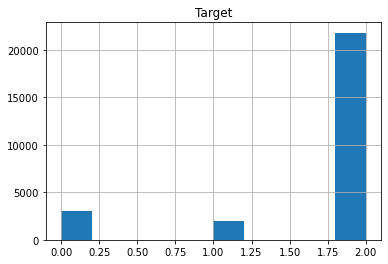

In [13]:
df_NEW[["Target"]].hist()

If we follow the values CM21 used for each class, we should be using:
* Training
    * 1472 YSOs (331 CI and 1141 CII)
    * 857 EG (231 Gals, 529 AGN, 27 PAHs 70 Shocks)
    * 1257 Stars
* Validation
    * 613 YSOs (82 CI and 531 CII)
    * 405 EG (104 Gals, 278 AGNs, 6 PAHs, 17 Shocks)
    * 4359 Stars

We will use the above input and compare to using 1000 of each class. There are a total of:
* 3073 YSOs
* 2034 EG
* 21 796 Stars


In [47]:
print(df_YSO.shape)
print(df_EG.shape)
print(df_Stars.shape)

(2590, 19)
(911, 19)
(608, 19)


## SPICY YSO Classification

In [67]:
df_SPICY = pd.read_csv("Data_and_Results/SPICY_YSO_Subclasses.csv",comment='#')

df_SPICY.head()

,SPICY,RAdeg DEdeg,GLON GLAT,p1,p2,p3,class,Si,PAH,alpha,...,ag.1,ag.2,ag.3,2MASS,UKIDSS,VIRAC,GaiaDR2,MIPS,WISEA,ZTFDR3
0,1,125.664811 -37.551349,255.975183 -0.253369,0.710000,,,ClassII,0,0,-1.51695368300395E+00,...,2,2,2,08223956-3733048,,,5541983493883598976,,J082239.55-373304.5,NaN
1,2,125.795513 -37.585000,256.062070 -0.187675,0.690000,,,ClassII,0,0,-6.43206342197073E-01,...,2,2,2,08231092-3735060,,,5541980848188474496,,J082310.90-373505.9,NaN
2,3,125.860244 -37.577463,256.085297 -0.141319,0.870000,,,FS,0,0,-2.14090416881411E-03,...,2,2,2,08232646-3734388,,,5541969475116705664,,J082326.45-373438.8,NaN
3,4,125.946863 -37.770809,256.282985 -0.196119,0.530000,,,ClassI,0,0,3.37295842881326E-01,...,4,2,4,,,,,,J082347.25-374615.0,NaN
4,5,126.003155 -37.126075,255.780917 0.210831,0.540000,,,FS,0,0,-2.78597489454348E-01,...,2,2,2,08240071-3707341,,,5542020537982099840,,J082400.75-370733.7,NaN


In [83]:
df_SPICY_IRAC = df_SPICY[[" SPICY","3.6mag","e_3.6mag","4.5mag","e_4.5mag","5.8mag","e_5.8mag","8.0mag","e_8.0mag","class    "]]
df_SPICY_IRAC = df_SPICY_IRAC[df_SPICY_IRAC["8.0mag"]!='      ']
df_SPICY_IRAC = df_SPICY_IRAC[df_SPICY_IRAC["5.8mag"]!='      ']

df_SPICY_IRAC.head()

,SPICY,3.6mag,e_3.6mag,4.5mag,e_4.5mag,5.8mag,e_5.8mag,8.0mag,e_8.0mag,class
0,1,13.158,0.063,12.800,0.104,12.470,0.153,12.009,0.083,ClassII
1,2,13.180,0.059,12.727,0.097,12.241,0.120,11.404,0.059,ClassII
2,3,11.703,0.052,11.197,0.061,10.674,0.059,9.576,0.034,FS
3,4,14.271,0.096,13.398,0.084,12.462,0.142,11.478,0.045,ClassI
4,5,13.198,0.065,12.393,0.084,11.726,0.077,10.848,0.048,FS


In [84]:
df_SPICY_CI = df_SPICY_IRAC[df_SPICY_IRAC["class    "]=="ClassI   "]
df_SPICY_CI["Target"] = 0

df_SPICY_CII = df_SPICY_IRAC[df_SPICY_IRAC["class    "]=="ClassII  "]
df_SPICY_CII["Target"] = 1

df_SPICY_CFS = df_SPICY_IRAC[df_SPICY_IRAC["class    "]=="FS       "]
df_SPICY_CFS["Target"] = 2

df_SPICY_CIII = df_SPICY_IRAC[df_SPICY_IRAC["class    "]=="ClassIII "]
df_SPICY_CIII["Target"] = 3

df_YSO_NEW_1 = pd.merge_ordered(df_SPICY_CI,df_SPICY_CII)
df_YSO_NEW_2 = pd.merge_ordered(df_SPICY_CFS,df_SPICY_CIII)
df_YSO_NEW = pd.merge_ordered(df_YSO_NEW_1,df_YSO_NEW_2)

df_YSO_NEW.head()

/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_58628/1182919758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SPICY_CI["Target"] = 0
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_58628/1182919758.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SPICY_CII["Target"] = 1
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_58628/1182919758.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

,SPICY,3.6mag,e_3.6mag,4.5mag,e_4.5mag,5.8mag,e_5.8mag,8.0mag,e_8.0mag,class,Target
0,1,13.158,0.063,12.800,0.104,12.470,0.153,12.009,0.083,ClassII,1
1,2,13.180,0.059,12.727,0.097,12.241,0.120,11.404,0.059,ClassII,1
2,3,11.703,0.052,11.197,0.061,10.674,0.059,9.576,0.034,FS,2
3,4,14.271,0.096,13.398,0.084,12.462,0.142,11.478,0.045,ClassI,0
4,5,13.198,0.065,12.393,0.084,11.726,0.077,10.848,0.048,FS,2


In [86]:
Inputs = df_YSO_NEW[["3.6mag","e_3.6mag","4.5mag","e_4.5mag","5.8mag","e_5.8mag","8.0mag","e_8.0mag"]].values.astype(float)
Targets = df_YSO_NEW[["Target"]].values.astype(float)


np.save("Data_and_Results/Inputs_YSO_Train.npy",Inputs)
np.save("Data_and_Results/Targets_YSO_Train.npy",Targets)

In [82]:
df_EMPTY = df_YSO_NEW[df_YSO_NEW["5.8mag"]=='      ']

df_EMPTY

,SPICY,3.6mag,e_3.6mag,4.5mag,e_4.5mag,5.8mag,e_5.8mag,8.0mag,e_8.0mag,class,Target
69,71,14.265,0.089,13.546,0.133,,,12.198,0.128,ClassII,1
127,129,13.785,0.065,13.199,0.124,,,12.361,0.114,ClassII,1
621,625,13.722,0.080,13.149,0.124,,,12.145,0.122,ClassII,1
946,951,14.138,0.130,13.381,0.194,,,11.983,0.145,ClassII,1
1077,1082,14.193,0.094,13.540,0.132,,,12.488,0.210,ClassII,1
...,...,...,...,...,...,...,...,...,...,...,...
102849,115100,11.583,0.029,11.112,0.018,,,9.792,0.042,ClassII,1
103196,115526,9.337,0.024,8.426,0.023,,,6.703,0.015,FS,2
104716,117103,13.159,0.039,12.671,0.028,,,11.608,0.052,ClassII,1
104941,117333,13.544,0.047,13.020,0.037,,,11.776,0.098,ClassII,1


In [87]:
print(df_SPICY_CI.shape)
print(df_SPICY_CII.shape)
print(df_SPICY_CFS.shape)
print(df_SPICY_CIII.shape)

(15596, 11)
(59561, 11)
(23563, 11)
(5333, 11)
